<a href="https://colab.research.google.com/github/satadrudas98/Photonic_Ising_chip/blob/main/photonic_ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

DO THIS: TAKE SEVERAL RUN AND AVERAGE IT OUT TO SEE THE PERFORMANCE ACROSS alpha AND beta

# Proof of Concept

##Cosine 

In [2]:

N=100 #number of spins
a= np.zeros([N,1])
traj=a
N_iter=10

alpha_min=0
alpha_max=2
alpha_step=0.01

x_ticks=[]

freq_x=10# for getting xticks

for i,alpha in enumerate(np.arange(alpha_min,alpha_max,alpha_step)):
  
  for j in range(N_iter):
    a=np.cos(alpha*a-np.pi/2+np.random.normal(scale=0.1,size=(N,1)))
  traj = np.c_[traj,a]
  if(i%freq_x==0):
    x_ticks.append(np.around(alpha,3))



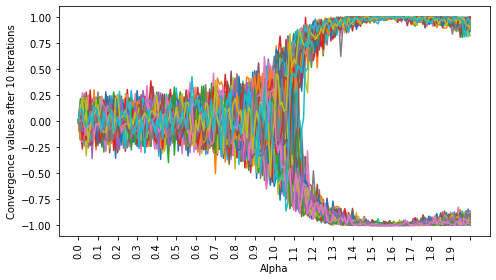

In [3]:
x=np.arange(((alpha_max-alpha_min)/alpha_step)*N_iter+1)
x=np.arange(((alpha_max-alpha_min)/alpha_step)+1)
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True

plt.xlabel('Alpha')
plt.ylabel('Convergence values after {} iterations'.format(N_iter))

for i in range(N):
  plt.plot(x,traj[i][:])
plt.xticks(np.arange(0,np.shape(traj)[1],freq_x),x_ticks,rotation='vertical')
plt.show()

## MAXCUT 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys


N = 3           # Number of spins
N_iters = 50   # Number of iterations per run
N_runs = 10     # Number of runs 

max_alpha = 2.0
min_alpha = 0.0
alpha_step = 0.1
plot_alpha = 0.4

max_beta = 2.0
min_beta = 0.1
beta_step = 0.1
plot_beta = (max_beta + min_beta)/2

sig = 0.04          # Std Deviation of noise 
V_pi = 1.0          # V_pi of the modulator
I0 = 1.0            # Action of photodiode and MZM
DC_bias = V_pi/2   # Action of DC_bias

scaling = 1.0

J_file = 0          #Flags which enable and disable different features
bifurcation = 0 
trajectory = 0
legend = 0
solver = 0
data_file = 0
tanh_switch = 1

In [5]:
tanh_switch = 0

In [6]:
#print("sys.argv is :",sys.argv)
if(len(sys.argv)>1):
    i = 1
    while(i <= len(sys.argv[1:])):
        opt = str(sys.argv[i])
        #print(opt)

        #Alpha parameters
        if(opt == '-aplt'):
            plot_alpha = float(sys.argv[i+1])
        elif(opt == '-ua'):
            max_alpha = float(sys.argv[i+1])
        elif(opt == '-da'):
            min_alpha = float(sys.argv[i+1])
        elif(opt == '-sa'):
            alpha_step = float(sys.argv[i+1])
        elif(opt == '-a'):
            min_alpha = float(sys.argv[i+1])
            max_alpha = min_alpha + 1e-10
            plot_alpha = min_alpha
        
        #Beta parameters
        elif(opt == '-bplt'):
            plot_beta = float(sys.argv[i+1])
        elif(opt == '-ub'):
            max_beta = float(sys.argv[i+1])
        elif(opt == '-db'):
            min_beta = float(sys.argv[i+1])
        elif(opt == '-sb'):
            beta_step = float(sys.argv[i+1])
        elif(opt == '-b'):
            min_beta = float(sys.argv[i+1])
            max_beta = min_beta + 1e-10
            plot_beta = min_beta

       #Run parameters
        elif(opt == '-iter'):
            N_iters = int(sys.argv[i+1])
        elif(opt == '-N'):
            N = int(sys.argv[i+1])
        elif(opt == '-run'):
            N_runs = int(sys.argv[i+1])

        #Modulator parameters
        elif(opt == '-dc'):
            DC_bias = float(sys.argv[i+1])
        elif(opt == '-o'):
            offset = float(sys.argv[i+1])
        elif(opt == '-I'):
            I0 = float(sys.argv[i+1])
        elif(opt == '-pi'):
            V_pi = float(sys.argv[i+1])

        #Scaling parameters
        elif(opt == "-scaling"):
            scaling = float(sys.argv[i+1])
        
        #Noise parameters
        elif(opt == '-sig'):
            sig = float(sys.argv[i+1])
        
        #Config parameters        
        elif(opt == '-J'):
            J_file = str(sys.argv[i+1])
        elif(opt == '-sol'):
            solver = 1
        elif(opt == '-traj'):
            trajectory = 1
        elif(opt == '-legend'):
            legend = 1
        elif(opt == '-bif'):
            bifurcation = 1
        elif(opt == '-data'):
            data_file = str(sys.argv[i+1])
        elif(opt == '-notanh'):
            tanh_switch = 0
        i+=1

In [26]:
J_file= "/content/s_100.txt"
N=100 
N_iter= 50
N_runs =2
sig= 0.05 
max_alpha= 3.0 
min_alpha= 0.1
alpha_step= 0.1 
max_beta= 3.0 
min_beta= 0.1
beta_step= 0.1 
trajectory = 1
bifurcation = 1
solver = 1
maxcut=180

In [27]:
#NOTE: I HAVE CORRECTED THE MODULATOR PHASE, AND NO NEED TO TAKE -alpha, INSTEAD WE HAVE TO TAKE -J SINCE IWE ARE CONSIDERING ANTIFERROMAGNETIC CASE HERE

def modulator(x):
  return I0*np.cos(x/V_pi-np.pi/2)

def feedback(x,alpha,beta,J):
    J = beta*(-J)#changing to antiferromagnetic
    np.fill_diagonal(J,alpha)
    return (J)@x

def notanh(x):
    for i,val in enumerate(x):
        if(val>=1):
            x[i] = 1
        elif(val<=-1):
            x[i] = -1
    return x        
    #return np.array([1 if i>=1 else -1 if i<=-1 else i for i in x])

def cut_value(cut):
    value = 0
    for row,i in enumerate(cut):
        for col,j in enumerate(cut):
            if(i*j<0):
                #print(i,j)
                #print("Row and column",row,col,J[row][col])
                value = value + J[row][col]
    return value/2

In [28]:
def hamiltonian(cut,J):
    H = 0
    J=-J  ####!!!!!!!!!!! REMEMBER ANTIFERRO, REMOVE THIS WHEN YOU HAVE CORRECTED THE J BEFORE ITSELF
    for row,i in enumerate(cut):
        for col,j in enumerate(cut):
            H = H -J[row][col]*i*j
    return H

In [29]:
#Initialize J to a ring if there is no input
J = np.zeros([N,N])
for i in range(1,N-1):
    J[i][i+1] = 1
    J[i][i-1] = 1

if(N >= 2):
    J[0][1] = 1
    J[0][N-1] = 1
    J[N-1][N-2] = 1
    J[N-1][0] = 1

#Load J from a file
if(J_file):
    f = open(J_file,"r")
    N, number_of_edges = [int(i) for i in f.readline().split()]
    J = np.zeros([N,N])
    lines = f.readlines()
    for line in lines:
        l = line.split()
        r,c,w = int(l[0])-1, int(l[1])-1, float(l[2])
        J[r][c] = w
        J[c][r] = w        
    f.close()
    print(J)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [30]:
np.sum(J)

360.0

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


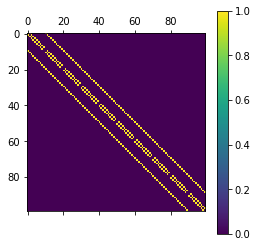

In [31]:
plt.matshow(J)
plt.colorbar()

In [ ]:
#Create Alpha and Beta arrays
Alpha = np.arange(min_alpha,max_alpha,alpha_step)
Beta = np.arange(min_beta,max_beta,beta_step)
switch = 0
final_x = np.zeros([N,1])
pre_final_x = np.zeros([N,1])
traj_x = np.zeros([N,1])



solutions = []
for alpha in Alpha:
    for beta in Beta:
        cut_sum=0
        for run in range(N_runs-1):
            
            x_k = np.zeros([N,1])
            x_in = np.zeros([N,1])
            #print("Working with Alpha = {}, Beta = {}, Run = {}".format(alpha,beta,run))
            i = 0
            traj_x = x_in
            noise = np.random.normal(0,sig,[N,N_iters])
            while(i < N_iters):
                # This is the calculated value to be put out to the DAC
                # Put the coupled equation instead later
                x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
                #print((x_out.T).shape)
                #print(type(x_out))
                #print("notanh(x_out)",notanh(x_out))
                # The value received from the modulator
                if(tanh_switch):
                    x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
                else:
                    x_in = 2*np.around(modulator(notanh(x_out))/2,3)

                # print(x_in)
                # The state value
                x_k = (V_pi)*((1/I0)*x_in)

                # print("x_k = ",x_k)
                i += 1
                # Add to trajectory
                traj_x = np.c_[traj_x,x_k]
            
            if(abs(np.around(alpha,3) - plot_alpha)<alpha_step and switch == 0 and abs(np.around(beta,3) - plot_beta)<beta_step):
                # plot trajectory   
                print("Plot alpha = {}\nAlpha = {}\nPlot Beta = {}\nBeta = {}\n".format(plot_alpha,alpha,plot_beta,beta))
                switch = 1
                if(trajectory):
                    plot1 = plt.figure(1)
                    for i in range(N):
                        plt.plot(traj_x[i],"-",label = "spin {}".format(i))
                    if(legend):
                        plt.legend()       
                    plt.title("Run number = {} Alpha = {} Beta = {} Cut = {}".format(run,np.around(alpha,3),np.around(beta,3),cut_value(np.sign(traj_x[:,-1]))))
                    plt.xlabel("Iteration Number")
                    plt.ylabel("State of the spin")
        
            pre_final_x = np.c_[pre_final_x,traj_x[:,-2]]
            final_x = np.c_[final_x,traj_x[:,-1]]
            cut = np.sign(traj_x[:,-1])
            cut_sum=cut_sum+cut_value(cut)
            #print(cut.shape)
            #print(cut_value(cut))
            #print(pre_final_x.shape,final_x.shape,cut.shape)
            if(solver):
                solutions.append([alpha,beta,run,cut_sum,cut,traj_x])








                #use the data in solution to plot

In [33]:
hamiltonian(np.sign(traj_x[:,-40]),J),np.sign(traj_x[:,-40])

(-264.0,
 array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,
         1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
         1.,  1., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,
        -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
        -1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1., -1.,
         1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.]))

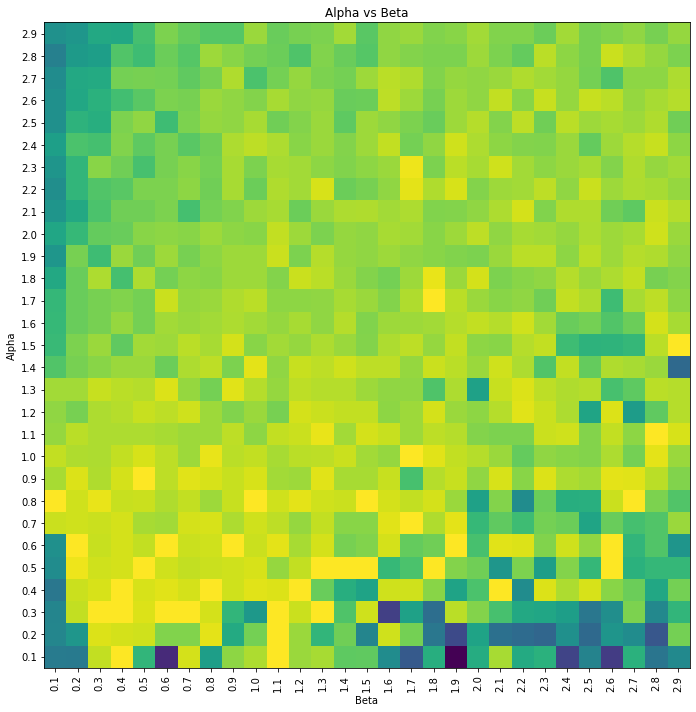

In [34]:
fig_cut=[]
for i in range(len(solutions)):
  fig_cut.append(solutions[i][3])

fig_cut=np.expand_dims(np.array(fig_cut), axis=-1)
fig_cut=fig_cut.T
fig_cut=fig_cut.reshape(len(Alpha),len(Beta))
fig_cut=np.flip(fig_cut, axis=0)

Alpha=np.round(Alpha, decimals=2)
Beta=np.round(Beta, decimals=2)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_yticks(np.arange(len(Alpha)-1,-1, -1))
ax.set_xticks(np.arange(0, len(Beta), 1), )
ax.set_xticklabels(Beta, rotation=90)
ax.set_yticklabels(Alpha,fontsize=10)
ax.set_title('Alpha vs Beta')
ax.set_xlabel("Beta")
ax.set_ylabel("Alpha")
im = ax.imshow(fig_cut)
#cbar = fig.colorbar(im)

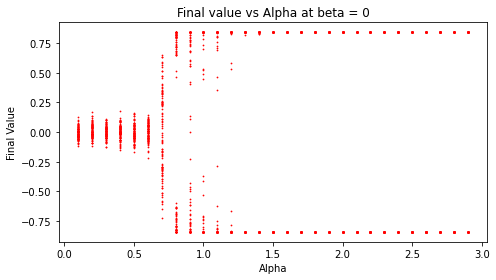

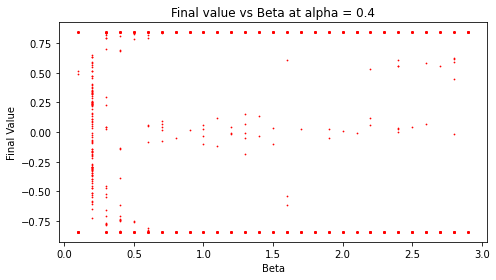

In [35]:

if(bifurcation):# to plot bifurcation graph
    plot2 = plt.figure(2)
    index_alpha = np.where(abs(Beta-plot_beta)<beta_step)
    plt.plot(Alpha,final_x[:,1::(N_runs-1)*len(Beta)].T,"r.",markersize=1.5)#[:np.where(plot_beta<Beta)[0][0]]
    plt.title("Final value vs Alpha at beta = 0")
    plt.xlabel("Alpha")
    plt.ylabel("Final Value")
    # Include plot against beta here. Need to choose an alpha for this
    plot3 = plt.figure(3)
    try:
        index_alpha = np.where(abs(Alpha-plot_alpha)<alpha_step)[0][0]
    except:
        plt.show()
        exit(0)
    index_alpha *= N_runs*len(Beta)
    plt.plot(Beta,final_x[:, index_alpha:index_alpha+(N_runs-1)*len(Beta):N_runs-1].T,"r.",markersize=1.5)
    plt.title("Final value vs Beta at alpha = {}".format(plot_alpha))
    plt.xlabel("Beta")
    plt.ylabel("Final Value")
    # # plt.plot(Alpha,pre_final_x[:,1:].T,"r.",markersize=0.5)

The best cut value that was obtained is: 
Cut value: 180.0
Alpha: 0.1
Beta: 0.4


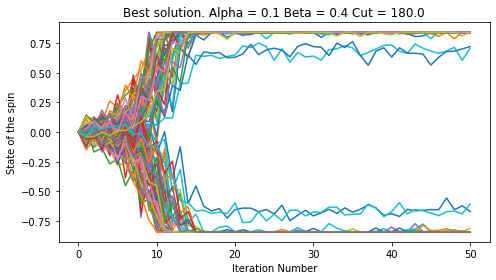

In [36]:
if(solver):
    opt_cut_value = -1e10
    opt_alpha = 0
    opt_beta = 0
    opt_cut = np.zeros(N)
    for i in solutions:
        if (i[3] > opt_cut_value):
            opt_cut_value = i[3]
            opt_alpha = i[0]
            opt_beta = i[1]
            opt_cut = i[4]
            opt_traj = i[5]
    # print("The nodes on two sides of the cut are: ")
    # print("The negative side:")
    # for node,i in enumerate(opt_cut):
    #     if(i<0):
    #         print(node+1)
    # print("The positive side:")
    # for node,i in enumerate(opt_cut):
    #     if(i>0):
    #         print(node+1)
    # #print(cut)
    # print("The number of positive nodes is: ",len(np.where(opt_cut>0)[0]))
    # print("The number of negative nodes is: ",len(np.where(opt_cut<0)[0]))

    print("The best cut value that was obtained is: ")
    print("Cut value: {}\nAlpha: {}\nBeta: {}".format(opt_cut_value,opt_alpha,opt_beta))
    plot4 = plt.figure(4)
    for i in range(N):
        plt.plot(opt_traj[i],"-",label = "spin {}".format(i))
    if(legend):
        plt.legend()       
    plt.title("Best solution. Alpha = {} Beta = {} Cut = {}".format(np.around(opt_alpha,3),np.around(opt_beta,3),opt_cut_value))
    plt.xlabel("Iteration Number")
    plt.ylabel("State of the spin")
    


plt.show()

In [42]:
def objective(alpha,beta):
 

  for run in range(N_runs-1):
    x_k = np.zeros([N,1])
    x_in = np.zeros([N,1])
    i = 0
    traj_x = x_in
    noise = np.random.normal(0,sig,[N,N_iters])
    while(i < N_iters):
      x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
      if(tanh_switch):
        x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
      else:
        x_in = 2*np.around(modulator(notanh(x_out))/2,3)


      x_k = (V_pi)*((1/I0)*x_in)
      i += 1
      traj_x = np.c_[traj_x,x_k]
      cut = np.sign(traj_x[:,-1])
      

  return cut_value(cut),traj_x




alpha=0.3
beta=0.3

cut,traj_x=objective(alpha,beta)
cut

180.0

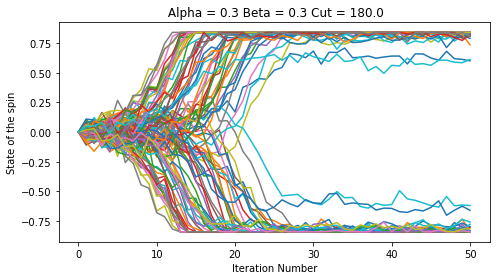

In [43]:
plot1 = plt.figure()
for i in range(N):
  plt.plot(traj_x[i],"-",label = "spin {}".format(i))
  if(legend):
    plt.legend()       
  plt.title(" Alpha = {} Beta = {} Cut = {}".format(np.around(alpha,3),np.around(beta,3),cut_value(np.sign(traj_x[:,-1]))))
  plt.xlabel("Iteration Number")
  plt.ylabel("State of the spin")

## Bayesian Optimization to get the best parameters

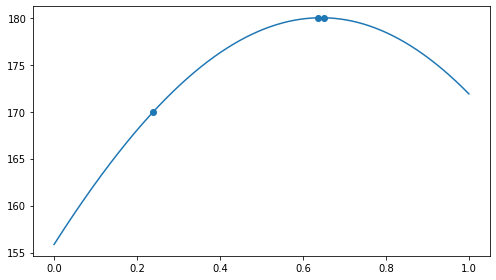

>x=0.758, f()=179.153099, actual=169.000
>x=0.003, f()=280.147290, actual=100.000
>x=0.057, f()=131.252126, actual=82.000
>x=0.535, f()=198.249900, actual=168.000
>x=0.711, f()=184.250273, actual=172.000
>x=0.382, f()=185.742355, actual=170.000
>x=0.457, f()=167.146111, actual=166.000
>x=0.662, f()=179.517065, actual=169.000
>x=0.233, f()=164.240036, actual=171.000
>x=0.701, f()=176.857403, actual=171.000


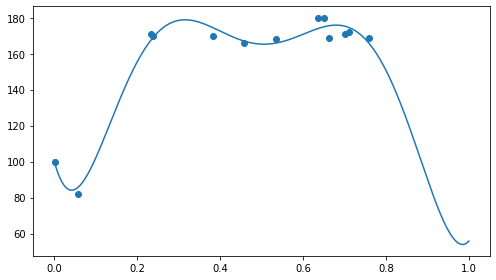

Best Result: x=0.637, y=180.000


In [44]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# objective function
def objective(alpha,beta):

  for run in range(N_runs-1):
    x_k = np.zeros([N,1])
    x_in = np.zeros([N,1])
    i = 0
    traj_x = x_in
    noise = np.random.normal(0,sig,[N,N_iters])
    while(i < N_iters):
      x_out = 2*np.around((feedback(x_k, alpha,beta,J) + np.array([noise[:,i]]).T)/2,3)
      if(tanh_switch):
        x_in = 2*np.around(modulator(np.tanh(x_out))/2,3)
      else:
        x_in = 2*np.around(modulator(notanh(x_out))/2,3)


      x_k = (V_pi)*((1/I0)*x_in)
      i += 1
      traj_x = np.c_[traj_x,x_k]
      cut = np.sign(traj_x[:,-1])

  return cut_value(cut)

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True) #should take 2 inputs.

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(10)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()
 








X = random(3)
y = asarray([objective(0.5,x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)


# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)




# perform the optimization process
for i in range(10):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(0.5,x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In [45]:
pip install bayesian-optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'alpha': (0.0, 1.0),
           'beta': (0.0, 1.0)
          }

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=2, n_iter=10,)
time_took = time.time() - start_time


print(optimizer.max)

|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
| 1         | 180.0     | 0.417     | 0.7203    |
| 2         | 11.0      | 0.0001144 | 0.3023    |
| 3         | 171.0     | 0.415     | 0.725     |
| 4         | 171.0     | 0.4491    | 0.6457    |
| 5         | 180.0     | 0.4487    | 0.6497    |
| 6         | 173.0     | 0.4948    | 0.7088    |
| 7         | 170.0     | 0.3658    | 0.6581    |
| 8         | 172.0     | 0.2241    | 0.6262    |
| 9         | 174.0     | 0.2407    | 0.5276    |
| 10        | 180.0     | 0.1535    | 0.5603    |
| 11        | 168.0     | 0.5532    | 0.702     |
| 12        | 180.0     | 0.1484    | 0.4067    |
{'target': 180.0, 'params': {'alpha': 0.417022004702574, 'beta': 0.7203244934421581}}


int

#CHIP COMPONENT SIMULATION

## Popping method

In [ ]:
## Insted of functions should I make them as classes?? ans instantiate them?????????????????


class MZI_dual_drive(): 

  '''
           /------ theta_1 ------\       
    ______/                       \_______
          \                       /
           \------ theta_2 ------/    
           

  For getting real amplitudes, the top arm should be given +theta (V_theta)
  and the bottom arm should be given -theta (2*V_pi-V_theta)....
  the above calculation will be done in the electronic part


  ################################################################
  ALSO REMEMBER TO ADD THE -PI/2 PHASE BIAS...to be adden in the electronics part
  ################################################################
  '''

  '''
  Arguements:
  modulating frequency
  voltage for top shifter(or may be just do it with phase for now) #same as giving inputs in a DL class
  voltage for botton shifter
  loss in dB

  return:
  modulated amplitude , dtype=complex
  '''

  def __init__(self,V_pi,efficiency,loss, input_amplitude):
    self.V_pi=V_pi
    self.efficiency=efficiency
    self.loss=loss
    self.input_amplitude=1



  def __call__(self,volt1,volt2):
    output_amplitude=self.input_amplitude*((np.exp(1j*np.pi*volt1/self.V_pi)+np.exp(1j*(np.pi*volt2/self.V_pi)))/2  )
    return output_amplitude






class tunable_unit(): 
  '''

  ------\        /------ theta_1 ------\       /------     
         \______/                       \_____/
          ______                         ______
         /      \                       /      \
  ------/        \------ theta_2 ------/        \------
  

  Arguements:
  the phases neede to get a Hadamard matrix
  the 2 input amplitudes

  return:
  the 2 output amplitudes
  '''

  # for Hadamard gate theta_1=(-np.pi/4) and theta_2=(-3*np.pi/4)

  def __init__(self,volt1,volt2,V_pi,loss):
    self.volt1=volt1#2*self.V_pi-self.V_pi*(np.pi/4)/np.pi ...ie volt of -theta_1....to be calculatedin the electronics
    self.volt2=volt2#2*self.V_pi-self.V_pi*(3*np.pi/4)/np.pi    
    self.V_pi=V_pi
    self.loss=loss

    self.theta_1=np.pi*volt1/self.V_pi
    self.theta_2=np.pi*volt2/self.V_pi
    self.delta_1=(self.theta_1+self.theta_2)/2
    self.delta_2=(self.theta_1-self.theta_2)/2


  def __call__(self,input_amplutude_1, input_amplitude_2):
    mat=(np.exp(-1j*(self.delta_1+np.pi/2)))*np.matrix([[np.sin(self.delta_2),np.cos(self.delta_2)],[np.cos(self.delta_2),-np.sin(self.delta_2)]])
    inpput=np.array([input_amplutude_1,input_amplitude_2])
    output=np.squeeze(np.array(np.matmul(mat,inpput)))
    return output




class homodyne_detector(): ## this would have the 2 detectors, 1 subtactor and 1 integrator 
  '''

  D------|
         |
         |________
          ________(-)--------[Integrator]--->
         |
         |
  D------| 



  Arguements:
  the 2 input amplitudes

  Return:
  The product, in the form of accumulated charge

  '''
  def __init__(self,gating_frequency, multiplying_factor):
    self.gating_frequency=gating_frequency
    self.multiplying_factor=multiplying_factor
    self.accumulated_value=0
    self.counter=0


  def detector_1(self,input_amplitude_1): # returns the power detected at the detector1
    input_amplitude_1=np.array(input_amplitude_1)
    detected_signal=input_amplitude_1.astype(complex)*np.conj(input_amplitude_1.astype(complex))
    return np.real(detected_signal) * self.multiplying_factor

  def detector_2(self,input_amplitude_2): # returns the power detected at the detector2
    input_amplitude_2=np.array(input_amplitude_2)
    detected_signal=input_amplitude_2.astype(complex)*np.conj(input_amplitude_2.astype(complex))
    return np.real(detected_signal) * self.multiplying_factor

  def subtractor(self,detected_power_1,detected_power_2): # subtracts the detected power,,dumbing it down..yes
    return (detected_power_1-detected_power_2)

  def integrator(self,value):
    self.accumulated_value=self.accumulated_value+value
    
      

  def __call__(self, input_amplitude_1, input_amplitude_2):
    d1=self.detector_1(input_amplitude_1)
    d2=self.detector_2(input_amplitude_2)
    s=self.subtractor(d1,d2)
    self.integrator(s)

    self.counter=self.counter+1
    
    if (self.counter%self.gating_frequency==0):
      acc=self.accumulated_value
      self.accumulated_value=0 ### since after every readout, the accumulator must be flushed
      return acc   ### the output would be (x_conj*y+x*y_conj)





class electronics_single_setup():

  ## remember to divide by 2 also
  '''
  Arguements:
  Input from the homodyne detectors

  Stores the J matrix

  Return:
  eletrical signal to control the modulator:
  mzi_1_v1, mzi_1_v2,mzi_2_v1, mzi_2_v2

  vectors basically, 
  '''

  def __init__(self,J,N,V_pi):
    self.J=J
    #self.J_flat=self.J.flatten()

    self.N=N
    self.V_pi=V_pi
    self.proportionality_constant=1
    
    
    self.x_in=np.zeros(self.N) # the input vector recorded element wise from the homodyne detector
    self.x_out=np.zeros(self.N) # the input phase to the the MZIs


    self.counter=0 # used for output to the MZIs (all set, this is correct)
    self.counter2=0 # used to  input from the homodyne
    self.std=0.05
    self.alpha=0
    self.beta=0


    # will be calculated based the phase input needed to be given
    self.mzi_1_v1=0 
    self.mzi_1_v2=0 
    self.mzi_2_v1=0
    self.mzi_2_v2=0



  @property
  def x_out_flat(self):
    x=self.x_out

    for i in range(self.N-1):
      x=np.concatenate((x,self.x_out))
    return x


  def __call__(self,alpha,beta,x=None):

    self.alpha=alpha
    self.beta=beta

    j_mat = self.beta*(-self.J)#changing to antiferromagnetic
    j_mat=np.fill_diagonal(j_mat,self.alpha)
    J_flat=j_mat.flatten()


    self.counter=self.counter+1 ## have to reset after n squared
    if (self.counter==self.N*self.N): ## because of python indexing ends at N-1
      self.counter=0 ## reset output counter


    if self.counter2==len(self.N)-1:
      self.x_out=self.x_in

      
    mzi_1_theta=self.x_out_flat[self.counter]-(np.pi/2)+np.random.normal(scale=self.std) #  +self.beta*    # add the beta j
    mzi_2_theta=self.J_flat[self.counter]

    self.mzi_1_v1=(self.V_pi/np.pi)*(mzi_1_theta) # theta
    self.mzi_1_v2=(2*self.V_pi-self.mzi_1_v1) # 2*pi-theta

    self.mzi_2_v1=(self.V_pi/np.pi)*(mzi_2_theta) #theta
    self.mzi_2_v2=(2*self.V_pi-self.mzi_2_v1) #2*pi-theta

    if x:
      self.counter2=self.counter2+1

      if (self.counter2==self.N):
        self.counter2=0 # reset input counter
        self.x_in=np.zeros(self.N) #update the old spins to new spin state

      self.x_in[self.counter2]=x

    return  self.mzi_1_v1,self.mzi_1_v2,self.mzi_2_v1,self.mzi_2_v2




class electronics_parallel_setup():
  '''
  Arguements:
  Input from the homodyne detectors

  Stores the J matrix
  the weights
  the fanout number

  Return:
  eletrical signal to control the modulator:
  mzi_1_v1, mzi_1_v2,mzi_2_v1, mzi_2_v2
  '''

  def __init__(self,J,N):
    self.J=J
    self.N=N

    self.mzi_1_v1=0
    self.mzi_1_v2=0
    self.mzi_2_v1=0
    self.mzi_2_v2=0

  def __call__():
    return 

## The single iteration string method

In [ ]:
def cut_value(cut):
    value = 0
    for row,i in enumerate(cut):
        for col,j in enumerate(cut):
            if(i*j<0):
                #print(i,j)
                #print("Row and column",row,col,J[row][col])
                value = value + J[row][col]
    return value/2

In [ ]:
def hamiltonian(cut,J):
    H = 0
    J=-J  ####!!!!!!!!!!! REMEMBER ANTIFERRO, REMOVE THIS WHEN YOU HAVE CORRECTED THE J BEFORE ITSELF
    for row,i in enumerate(cut):
        for col,j in enumerate(cut):
            H = H -J[row][col]*i*j
    return H

In [ ]:


class MZI_dual_drive(): 

  '''
           /------ theta_1 ------\       
    ______/                       \_______
          \                       /
           \------ theta_2 ------/    
           

  For getting real amplitudes, the top arm should be given +theta (V_theta)
  and the bottom arm should be given -theta (2*V_pi-V_theta)....
  the above calculation will be done in the electronic part


  Arguements:
  modulating frequency
  voltage for top shifter
  voltage for botton shifter
  loss in dB

  return:
  modulated amplitude , dtype=complex
  '''

  def __init__(self,V_pi,efficiency,loss, input_amplitude=1):
    self.V_pi=V_pi
    self.efficiency=efficiency
    self.loss=loss
    self.input_amplitude=input_amplitude



  def __call__(self,volt1,volt2):
    
    output_amplitude=self.input_amplitude*((np.exp(1j*np.pi*volt1/self.V_pi)+np.exp(1j*(np.pi*volt2/self.V_pi)))/2  )
    return output_amplitude






class tunable_unit(): 
  '''

  ------\        /------ theta_1 ------\       /------     
         \______/                       \_____/
          ______                         ______
         /      \                       /      \
  ------/        \------ theta_2 ------/        \------
  

  Arguements:
  the phases neede to get a Hadamard matrix
  the 2 input amplitudes

  return:
  the 2 output amplitudes

  2*self.V_pi+(self.V_pi/np.pi)*(theta1)
   
  '''

  # for Hadamard gate theta_1=(-np.pi/4) and theta_2=(-3*np.pi/4)

  def __init__(self,volt1,volt2,V_pi,loss):
    self.volt1=volt1#2*self.V_pi-self.V_pi*(np.pi/4)/np.pi ...ie volt of -theta_1....to be calculatedin the electronics
    self.volt2=volt2#2*self.V_pi-self.V_pi*(3*np.pi/4)/np.pi    
    self.V_pi=V_pi
    self.loss=loss

    self.theta_1=np.pi*volt1/self.V_pi
    self.theta_2=np.pi*volt2/self.V_pi
    self.delta_1=(self.theta_1+self.theta_2)/2
    self.delta_2=(self.theta_1-self.theta_2)/2


  def __call__(self,input_amplutude_1, input_amplitude_2):
    mat=(np.exp(-1j*(self.delta_1+np.pi/2)))*np.matrix([[np.sin(self.delta_2),np.cos(self.delta_2)],[np.cos(self.delta_2),-np.sin(self.delta_2)]])
    inpput=np.array([input_amplutude_1,input_amplitude_2])
    output=np.squeeze(np.array(np.matmul(mat,inpput)))
    return output


class homodyne_detector_batch(): ## will return one x value
  '''

  D------|
         |
         |________
          ________(-)--------[Integrator]--->
         |
         |
  D------| 



  Arguements:
  the 2 input amplitudes

  Return:
  The product*2*factor

  '''
  def __init__(self, N,multiplying_factor):
    self.multiplying_factor=multiplying_factor
    self.N=N
    self.accumulated_value=0


  def detector(self,input_amplitude): # returns the power detected at the detector1
      input_amplitude=np.array(input_amplitude)
      detected_signal=input_amplitude.astype(complex)*np.conj(input_amplitude.astype(complex))
      return np.real(detected_signal) * self.multiplying_factor


  def subtractor(self,detected_power_1,detected_power_2): # subtracts the detected power,,dumbing it down..yes
    return (detected_power_1-detected_power_2)

    
    
  def __call__(self, input_amplitude_1, input_amplitude_2,read=None):
    d1=self.detector(input_amplitude_1)
    d2=self.detector(input_amplitude_2)
    s=self.subtractor(d1,d2)

    if read:#read flag for final readout
      return s

    else:

      x=np.array(np.split(s, self.N))
      x=x.sum(axis=1)
      return x  # the input to electronics class


    
class electronics_single_batch():

  '''
  Arguements:
  Input from the homodyne detectors

  Stores the J matrix

  Return:
  eletrical signal to control the modulator:
  mzi_1_v1, mzi_1_v2,mzi_2_v1, mzi_2_v2

  vectors basically, 
  '''

  def __init__(self,J,N,alpha, beta,V_pi):
    self.alpha=alpha
    self.beta=beta
    self.J=J


    self.N=N
    self.V_pi=V_pi
    self.std=0.05
    
    self.x_out=np.zeros(self.N) # the input phase to the the MZIs

    # will be calculated based the phase input needed to be given
    self.mzi_1_v1=0 
    self.mzi_1_v2=0 
    self.mzi_2_v1=0
    self.mzi_2_v2=0


  @property
  def J_flat(self):
    j=self.beta*(-self.J)
    np.fill_diagonal(j,self.alpha)
    j=j.flatten()
    return j

  @property
  def J_max(self):
    j=np.abs(self.J_flat)
    return self.j.max()


    ########################### the above is same as just finding the max of alpha and beta
  @property
  def max_divider(self):
    a=np.abs(self.alpha)
    b=np.abs(self.beta)
    return max(a,b)


  @property
  def J_theta(self): ## theta for notmalized J
    return np.arccos(self.J_flat/(self.max_divider+1e-15)) # normalizing and then taking cosine inverse
    

    

  @property
  def x_out_flat(self):
    return np.tile(self.x_out,self.N)
  
  


  def __call__(self,x,read=None): # x here is of size N, not N*N

    if read: # read flag is given when we are doing the final read out
      self.x_out=x*self.max_divider/2 # we are multiplying to compensate for the division we did for the modulation
        
      mzi_1_theta=(self.x_out-(np.pi/2)) #/self.J_max no need to divide here, since we are going to multiply Jmax anyway in the detection side again
      mzi_2_theta=self.J_theta 

      self.mzi_1_v1=2*self.V_pi+(self.V_pi/np.pi)*(mzi_1_theta) # theta ## make it 2pi + theta
      self.mzi_1_v2=2*self.V_pi-(self.V_pi/np.pi)*(mzi_1_theta) # 2*pi-theta

      self.mzi_2_v1=2*self.V_pi+(self.V_pi/np.pi)*(mzi_2_theta) #theta
      self.mzi_2_v2=2*self.V_pi-(self.V_pi/np.pi)*(mzi_2_theta) #2*pi-theta


      return self.mzi_1_v1,self.mzi_1_v2,self.mzi_2_v1,self.mzi_2_v2 ### a long array of a single iterations of matrix multiplication....      



    else:


      self.x_out=x*self.max_divider/2 # we are multiplying to compensate for the division we did for the modulation
        
      mzi_1_theta=(self.x_out_flat-(np.pi/2)+np.random.normal(scale=self.std,size=(len(self.x_out_flat)))) #/self.J_max no need to divide here, since we are going to multiply Jmax anyway in the detection side again
      mzi_2_theta=self.J_theta 

      self.mzi_1_v1=2*self.V_pi+(self.V_pi/np.pi)*(mzi_1_theta) # theta ## make it 2pi + theta
      self.mzi_1_v2=2*self.V_pi-(self.V_pi/np.pi)*(mzi_1_theta) # 2*pi-theta

      self.mzi_2_v1=2*self.V_pi+(self.V_pi/np.pi)*(mzi_2_theta) #theta
      self.mzi_2_v2=2*self.V_pi-(self.V_pi/np.pi)*(mzi_2_theta) #2*pi-theta


      return self.mzi_1_v1,self.mzi_1_v2,self.mzi_2_v1,self.mzi_2_v2 ### a long array of a single iterations of matrix multiplication....




In [ ]:
N=100 #number of spins
N_iter=50 # numbr of iterations

alpha_min=0
alpha_max=3
alpha_step=0.1

beta_min=0
beta_max=3
beta_step=0.01

std=0.05
V_pi=1

v1=2*V_pi+(V_pi/np.pi)*(-np.pi/4)
v2=2*V_pi+(V_pi/np.pi)*(-3*np.pi/4)

'''
  2*self.V_pi+(self.V_pi/np.pi)*(theta1)
   

  # for Hadamard gate theta_1=(-np.pi/4) and theta_2=(-3*np.pi/4)
'''

'\n  2*self.V_pi+(self.V_pi/np.pi)*(theta1)\n   \n\n  # for Hadamard gate theta_1=(-np.pi/4) and theta_2=(-3*np.pi/4)\n'

In [ ]:
J_file= "/content/s_100.txt"


In [ ]:
#Initialize J to a ring if there is no input
J = np.zeros([N,N])
for i in range(1,N-1):
    J[i][i+1] = 1
    J[i][i-1] = 1

if(N >= 2):
    J[0][1] = 1
    J[0][N-1] = 1
    J[N-1][N-2] = 1
    J[N-1][0] = 1

#Load J from a file
if(J_file):
    f = open(J_file,"r")
    N, number_of_edges = [int(i) for i in f.readline().split()]
    J = np.zeros([N,N])
    lines = f.readlines()
    for line in lines:
        l = line.split()
        r,c,w = int(l[0])-1, int(l[1])-1, float(l[2])
        J[r][c] = w
        J[c][r] = w        
    f.close()
    print(J)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
'''
The main loop:

initializing x=np.zeros(N)

1. elecronics_single_batch
2. MZI_dual_drive1, MZI_dual_drive2
3. tunable element
4. homodyne_detection_batch
5. feedback new x to (1)

For reading out the spin status, just sent np.ones(N) in MZI_2,
then the product will be just x


'''

'\nThe main loop:\n\ninitializing x=np.zeros(N)\n\n1. elecronics_single_batch\n2. MZI_dual_drive1, MZI_dual_drive2\n3. tunable element\n4. homodyne_detection_batch\n5. feedback new x to (1)\n\nFor reading out the spin status, just sent np.ones(N) in MZI_2,\nthen the product will be just x\n\n\n'

In [ ]:
mzi1=MZI_dual_drive(V_pi,1,1,1)
mzi2=MZI_dual_drive(V_pi,1,1,1)
tu=tunable_unit(v1,v2,V_pi,1)
homodyne=homodyne_detector_batch(N,1)
electronics=electronics_single_batch(J,N,0.4,0.4,V_pi)


final_readout_homodyne=homodyne_detector_batch(1,1)



In [ ]:
x=np.zeros(N)
traj=x

for i in range(N_iter):
  mzi_volt=electronics(x)
  x_n=mzi1(mzi_volt[0],mzi_volt[1])
  y_n=mzi2(mzi_volt[2],mzi_volt[3])
  h=tu(x_n,y_n)
  x_new=homodyne(h[0],h[1])
  x=x_new
  traj= np.c_[traj,x_n[0:N]]
  


cut = np.sign(traj[:,-1])


print('The final cut value is: {}'.format(cut_value(cut)))

The final cut value is: 180.0


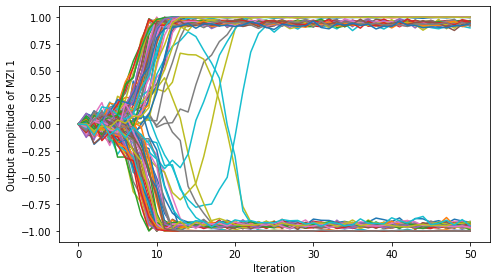

The final cut value is: 180.0


In [ ]:
xx=np.arange(N_iter+1)
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True
for i in range(len(traj)):
  plt.plot(xx,np.real(traj[i,:]))
plt.ylabel('Output amplitude of MZI 1')
plt.xlabel('Iteration')
plt.show()



print('The final cut value is: {}'.format(cut_value(cut)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


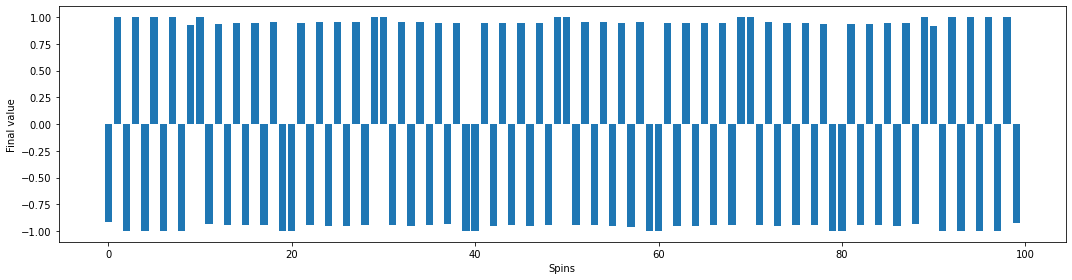

The final cut value is: 180.0


In [ ]:
### FINAL READ OUT FROM THE DETECTOR

mzi_volt=electronics(x,read=1)
x_n=mzi1(mzi_volt[0],mzi_volt[1])
y_n=mzi2(0,0)
h=tu(x_n,y_n)
x_new=homodyne(h[0],h[1],read=1)
x=x_new/2 #divide by 2 because of tthe 2 factor of the homodyne product




xf=np.arange(N)

plt.rcParams["figure.figsize"] = [15, 4]
plt.rcParams["figure.autolayout"] = True
plt.bar(xf,x)
plt.xlabel('Spins')
plt.ylabel('Final value')
plt.show()

cut = np.sign(x)
print('The final cut value is: {}'.format(cut_value(cut)))

In [ ]:
xg=np.reshape(x,(10,10))

/usr/local/lib/python3.7/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


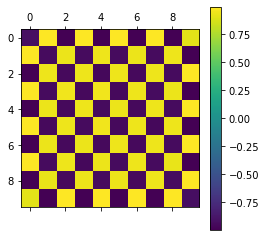

In [ ]:
plt.matshow(xg)
plt.colorbar()